In [2]:
import os
import numpy as np
from PIL import Image

# -----------------------------
# 1. PARAMETERS
# -----------------------------

image_size = (64,64) # Resizes all the loaded images into a size of 64X64 pixels 
data_directory = "Images" # Specifies the root directory containing the image sub-folders (ie. "Dogs" and "Cats")

# -----------------------------
# 2. LOAD IMAGES
# -----------------------------
def loading_images(data_directory,mode, image_size):

    """
    Loads images from the specified directory, resizes them, flattens them into vectors,
    and assigns labels based on folder names.

    Assumes each class has a subfolder with 'train' images.

    Arguments:
    data_directory -- string, path to the root directory containing class folders
    mode -- string, either 'train' or 'test' to specify which subfolder to load
    image_size -- tuple(int, int), size to which each image will be resized (width, height)

    Returns:
    X -- list of numpy arrays, each array is a flattened image vector
    y -- list of integers, labels corresponding to each image
    label_dict-- dictionary mapping class names (folder names) to integer labels, e.g., {'Dogs': 0, 'Cats': 1}
    """
    X = [] # Empty list for storing flattened image vectors 
    y = [] # Empty list for storing interger labels (0 and 1)
    
    # Get class labels from folder names and map to integers
    
    labels = os.listdir(data_directory) # lists all the sub-folders of the specified root directory, that contain the images
    label_dict = {label: i for i, label in enumerate(labels)}
    
    # Loop through each class folder and creates path for the mode
    for label in labels:
        folder = os.path.join(data_directory, label, mode)
        if not os.path.isdir(folder):
            continue  # Skip if train/test folder doesn't exist

        Files = os.listdir(folder)
        for filename in Files:
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(folder, filename)
               # Open image and convert to RGB
                img = Image.open(image_path).convert("RGB")
              # Resizes the loaded image into the size specified above (64x64 pixels)
                img_resized = img.resize(image_size)
              # Creates a numpy array from the resized image
                X_array = np.array(img_resized)
             # Flattens the array into a vector and appends it into X
                X.append(X_array.flatten())
             # Appends each class label into a list "y"
                y.append(label_dict[label])

    # Converts X into an array and normalizes all pixel values to [0,1]
    X_norm = (np.array(X))/255.0
    # Converts y labels into an array
    y_array = np.array(y)
    
    return X_norm, y_array, label_dict
    

In [3]:

# Assigning the outputs of the "loading_images" function to their respective variables
X_train, y_train, label_dict = loading_images("../Images", "train", image_size)
X_test, y_test = loading_images("../Images", "test", image_size)[:2]

# Transpose for math: changing dimensions to (features, training_examples)
X_train, X_test = X_train.T, X_test.T
y_train, y_test = y_train.reshape(1, y_train.shape[0]), y_test.reshape(1, y_test.shape[0])

In [289]:
# ------------------------------------
# 3. PARAMETER INITIALIZATION FUNCTION
# ------------------------------------

def parameter_init(input_size, hidden_1, hidden_2, hidden_3, output_size):
    """Initializes weights and biases for a 4-layer neural network.
    
    Arguments:    
    input_size -- int, number of input features (size of the input layer)
    hidden_1 -- int, number of units in the first hidden layer
    hidden_2 -- int, number of units in the second hidden layer
    hidden_3 -- int, number of units in the third hidden layer
    output_size -- int, number of units in the output layer
    
    Returns:
    parameters -- dict containing initialized weights (W1, W2, W3, W4) 
                  and biases (b1, b2, b3, b4) for each layer
    """
    np.random.seed(1)

    # Weights: initialized with small random values (scaled by 0.01)
    # to prevent exploding activations and help stable learning.
    # Biases: initialized to zero.
    W1 = np.random.randn(hidden_1, input_size)*np.sqrt(2. / input_size)
    b1 = np.zeros((hidden_1, 1))
    W2 = np.random.randn(hidden_2, hidden_1)*np.sqrt(2. / hidden_1)
    b2 = np.zeros((hidden_2,1))
    W3 = np.random.randn(hidden_3, hidden_2)*np.sqrt(2. / hidden_2)
    b3 = np.zeros((hidden_3,1))
    W4 = np.random.randn(output_size, hidden_3)*np.sqrt(1. / hidden_2)
    b4 = np.zeros((output_size,1))
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3":W3, "b3":b3, "W4":W4, "b4":b4}
    return parameters
    

# -----------------------------
# 4. ACTIVATION FUNCTIONS
# -----------------------------

def relu(Z):
    A = np.maximum(0,Z)
    return A
def relu_derivative(Z):
    return (Z>0).astype(float)
def sigmoid(Z4):
    Z4 = np.clip(Z4, -500, 500)
    y_hat = 1/(1 + np.exp(-Z4))
    return y_hat

def sigmoid_derivative(y_hat):
    y_hat_derivative = y_hat*(1-y_hat)
    return y_hat_derivative

# -------------------------------
# 5. FORWARD BACKWARD PROPAGATION
# -------------------------------

# Before calling this function, make sure to initialize parameters:
# parameters = parameter_init(input_size, hidden_1, hidden_2, hidden_3, output_size)
def forward_prop(X_train, parameters):

    # Retrieve weights and biases from dictionary
    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]
    W3, b3 = parameters["W3"], parameters["b3"]
    W4, b4 = parameters["W4"], parameters["b4"]

    Z1 = W1.dot(X_train) + b1
    A1 = relu(Z1)  
    Z2 = W2.dot(A1) + b2
    A2 = relu(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = relu(Z3)
    Z4 = W4.dot(A3) + b4
    y_hat = sigmoid (Z4)

    cache = {"Z1":Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3,"A3": A3,"Z4": Z4, "A4": y_hat}
    return cache

def Cost_function(y, y_hat):
    m = y.shape[1] # number of training examples

    eps = 1e-15
    y_hat = np.clip(y_hat, eps, 1 - eps)
    cost = -np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)) / m
    cost = np.squeeze(cost) 
    return cost
    
# -----------------------
# 5. BACKWARD PROPAGATION
# -----------------------

def backward_prop(parameters, cache, X_train, y_train):
    W1, W2, W3, W4 = parameters["W1"], parameters["W2"], parameters["W3"], parameters["W4"]
    A1, A2, A3, A4 = cache["A1"], cache["A2"], cache["A3"], cache["A4"]
    Z1, Z2, Z3, Z4 = cache["Z1"], cache["Z2"], cache["Z3"], cache["Z4"]
    
    m = X_train.shape[1]

    # Layer 4 (output layer)
    dZ4 = A4 - y_train
    dW4 = (1/m) * np.dot(dZ4, A3.T)
    db4 = (1/m) * np.sum(dZ4, axis=1, keepdims=True)

    # Hidden Layer 3
    dZ3 = np.dot(W4.T, dZ4) * relu_derivative(Z3)
    dW3 = (1/m) * np.dot(dZ3, A2.T)
    db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)

    # Hidden Layer 2
    dZ2 = np.dot(W3.T, dZ3) * relu_derivative(Z2)
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    # Hidden Layer 1
    dZ1 = np.dot(W2.T, dZ2) * relu_derivative(Z1)
    dW1 = (1/m) * np.dot(dZ1, X_train.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    max_grad = 1.0
    # Clip gradients for all layers
    dW1 = np.clip(dW1, -max_grad, max_grad)
    db1 = np.clip(db1, -max_grad, max_grad)

    dW2 = np.clip(dW2, -max_grad, max_grad)
    db2 = np.clip(db2, -max_grad, max_grad)

    dW3 = np.clip(dW3, -max_grad, max_grad)
    db3 = np.clip(db3, -max_grad, max_grad)

    dW4 = np.clip(dW4, -max_grad, max_grad)
    db4 = np.clip(db4, -max_grad, max_grad)

    derivatives = {
        "dW4": dW4, "db4": db4,
        "dW3": dW3, "db3": db3,
        "dW2": dW2, "db2": db2,
        "dW1": dW1, "db1": db1
    }
    
    return derivatives
# -----------------------------
# 6. PARAMETER UPDATE
# -----------------------------

def parameter_update(parameters, derivatives, learning_rate = 1.2):

    L = len(parameters) // 2  # number of layers
    for l in range(1, L + 1):
        #print(f"Layer {l}: mean|dW| = {np.mean(np.abs(derivatives[f'dW{l}'])):.6f}, "
         # f"mean|db| = {np.mean(np.abs(derivatives[f'db{l}'])):.6f}")
        parameters[f"W{l}"] -= learning_rate * derivatives[f"dW{l}"]
        parameters[f"b{l}"] -= learning_rate * derivatives[f"db{l}"]
    return parameters

In [298]:
# -------------------------------
# 7. TRAINING
# -------------------------------

from matplotlib import pyplot as plt

def train(X, y, input_size, hidden_1, hidden_2, hidden_3, output_size, epochs=1500):
    parameters = parameter_init(input_size, hidden_1, hidden_2, hidden_3, output_size)
    costs = []  # store cost for plotting
    best_cost = float("inf")
    best_params = parameters.copy()
    
    for epoch in range(epochs):
        cache = forward_prop(X, parameters)
        cost = compute_cost(y, cache["A4"])
        derivatives = backward_prop(parameters, cache, X, y)
        parameters = parameter_update(parameters, derivatives, learning_rate=0.001)

        costs.append(cost)
        #if epoch % 10 == 0:
         #   print(f"Epoch {epoch}, Cost: {cost:.6f}")

        # Track best parameters
        if cost < best_cost:
            best_cost = cost
            best_params = {k: v.copy() for k, v in parameters.items()}

    return best_params, costs

In [299]:
train(X_train, y_train, 12288,128,64,32,1)

({'W1': array([[ 0.02109367, -0.0073609 , -0.00602803, ..., -0.00634857,
          -0.00427107,  0.0123303 ],
         [ 0.01305918,  0.00312104, -0.0082718 , ...,  0.00909152,
          -0.0060004 ,  0.00297035],
         [-0.00471759, -0.0028297 ,  0.00749861, ...,  0.0102276 ,
          -0.00200734, -0.00865348],
         ...,
         [-0.01836438,  0.00530882,  0.00226068, ..., -0.00481766,
          -0.0126328 , -0.01204528],
         [ 0.02363195,  0.00510847,  0.01711916, ..., -0.00483567,
          -0.0009925 , -0.00296073],
         [ 0.00628444,  0.00824069,  0.00184049, ..., -0.01967985,
           0.03721137,  0.02380898]]),
  'b1': array([[-1.32351062e-03],
         [-1.47844706e-05],
         [ 1.48529381e-03],
         [ 2.98595719e-04],
         [-9.54881338e-04],
         [ 0.00000000e+00],
         [ 2.50166743e-03],
         [ 1.69431265e-04],
         [-6.83560769e-06],
         [-6.03046855e-04],
         [-1.97224564e-03],
         [ 4.10235634e-04],
         [-1

Layer 1: mean|dW| = 0.001472, mean|db| = 0.002483
Layer 2: mean|dW| = 0.001220, mean|db| = 0.002783
Layer 3: mean|dW| = 0.001370, mean|db| = 0.003537
Layer 4: mean|dW| = 0.023227, mean|db| = 0.061510
Epoch 0, Cost: 0.692531
Layer 1: mean|dW| = 0.001403, mean|db| = 0.002339
Layer 2: mean|dW| = 0.001159, mean|db| = 0.002651
Layer 3: mean|dW| = 0.001327, mean|db| = 0.003619
Layer 4: mean|dW| = 0.022034, mean|db| = 0.055251
Layer 1: mean|dW| = 0.001285, mean|db| = 0.002139
Layer 2: mean|dW| = 0.001155, mean|db| = 0.002677
Layer 3: mean|dW| = 0.001312, mean|db| = 0.003461
Layer 4: mean|dW| = 0.021071, mean|db| = 0.050020
Layer 1: mean|dW| = 0.001196, mean|db| = 0.001942
Layer 2: mean|dW| = 0.001076, mean|db| = 0.002428
Layer 3: mean|dW| = 0.001284, mean|db| = 0.003424
Layer 4: mean|dW| = 0.020334, mean|db| = 0.045019
Layer 1: mean|dW| = 0.001071, mean|db| = 0.001801
Layer 2: mean|dW| = 0.000992, mean|db| = 0.002097
Layer 3: mean|dW| = 0.001220, mean|db| = 0.003260
Layer 4: mean|dW| = 0.0197

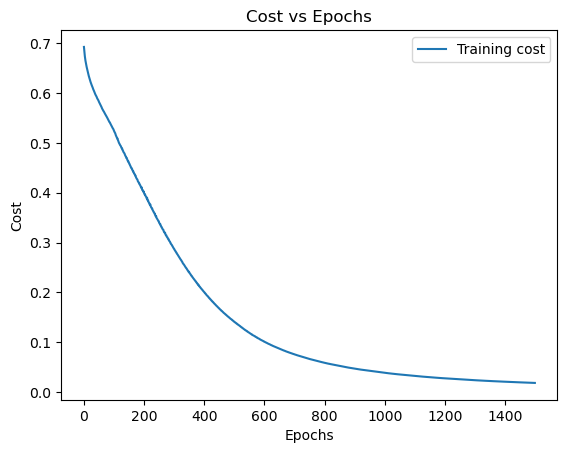

In [281]:
best_params, costs = train(X_train, y_train, 12288,128,64,32,1)
# Plot the cost curve
plt.plot(range(len(costs)), costs, label="Training cost")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cost vs Epochs")
plt.legend()
plt.show()

In [105]:
parameters=parameter_init(12288,128,64,32,1)

In [109]:
W2_before = parameters["W2"].copy()
parameters = parameter_update(parameters, derivatives, learning_rate=1.2)
W2_after = parameters["W2"]

print("Max change in W1:", np.max(np.abs(W1_after - W1_before)))

Layer 1: mean|dW| = 0.003552, mean|db| = 0.006000
Layer 2: mean|dW| = 0.003115, mean|db| = 0.007532
Layer 3: mean|dW| = 0.003795, mean|db| = 0.011754
Layer 4: mean|dW| = 0.038013, mean|db| = 0.119673
Max change in W1: 0.07966604463511338


In [93]:
cache = forward_prop(X_train, parameters)